In [1]:
from tifffile import imread, imwrite
import cv2
from PIL import Image
import numpy as np
from tensorflow import keras
import tensorflow as tf
import sys
from matplotlib import colors
import matplotlib.pyplot as plt
import itertools
from scipy.spatial.distance import pdist, squareform
from scipy import ndimage
from sklearn.cluster import KMeans, DBSCAN
import skimage.segmentation as seg
#from treeSeg import chunkify

In [10]:
def crop(img, x, y, len_x, len_y):
    cropped = img[y:y+len_y, x:x+len_x] #crops
    return cropped

In [4]:
def mark_img(im, coords,  x, y):
    input_im = im.copy()
    dim = 10
    for c in coords:
        ix = np.round(c[0]).astype('int')
        iy = np.round(c[1]).astype('int')
        image = cv2.circle(input_im, (iy, ix), radius=3, color=(255, 0, 0, 255), thickness=-1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(input_im)


In [3]:
def centers(im):
    input_im = im.copy()
    im = cv2.cvtColor(im, cv2.COLOR_BGRA2GRAY)
    mask = im > im.mean()
    lbl, n_labs = ndimage.label(mask)
    com = ndimage.measurements.center_of_mass(mask, labels=lbl, index=range(1, n_labs+1))
    return com

    

In [2]:
def filter_size(im, max_size=1800, min_size=200, sigma=3):
    input_im = im.copy()
    im = cv2.cvtColor(im, cv2.COLOR_BGRA2GRAY)

    im = ndimage.gaussian_filter(im, sigma=sigma) #sigma is critical to get right

    
    mask = im > im.mean()
    # Analysis of connected components
    # Label connected components: ndimage.label:

    label_im, nb_labels = ndimage.label(mask)
#     nb_labels # how many regions?

    plt.imshow(label_im)         

  
    # Compute size, mean_value, etc. of each region:

    # >>>
    sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
    mean_vals = ndimage.sum(im, label_im, range(1, nb_labels + 1))
    # Clean up small connect components:

    # >>>
    mask_size = (sizes < min_size) | (sizes > max_size)
    remove_pixel = mask_size[label_im]
    remove_pixel.shape

    label_im[remove_pixel] = 0
    input_im[remove_pixel] = 0

    return input_im

In [5]:
def slic(rgb, target, n_classes, display=False, show_all=False):
    labels1 = seg.slic(rgb[...,:-1], compactness=.000001, n_segments=n_classes,  convert2lab=True, enforce_connectivity=False, start_label=1)
    lookupTable, idx,  labels, counts = np.unique(labels1, return_inverse=True, return_counts=True, return_index=True)
    mask = np.zeros(rgb.shape[:2], dtype = "uint8")
    im = np.zeros(rgb.shape[:2], dtype = "uint8")
#     target = 1
    if display: 
        if show_all:
            f, axarr = plt.subplots(1,len(lookupTable))
            for (i, segVal) in enumerate(np.unique(labels1)):
                mask = np.zeros(rgb.shape[:2], dtype = "uint8")
                mask[labels1 == segVal] = 255
                axarr[i].axis('off')
                axarr[i].imshow(cv2.bitwise_and(rgb, rgb, mask = mask))
        else:
            mask[labels1 == target] = 1
            im = cv2.bitwise_and(rgb, rgb, mask = mask)
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(im)
            axarr[0].axis('off')
            axarr[1].imshow(rgb)
            axarr[1].axis('off')
            plt.show()  
    else:
        mask[labels1 == target] = 1
        im = cv2.bitwise_and(rgb, rgb, mask = mask)
        
    return im

In [24]:
def get_saps(im, target=1, n_classes=7, display=False, show_all=False, max_size=1800, min_size=200, sigma=3):
    slicced = slic(cropped, target, n_classes, display=display)
    slicced = slic(slicced, 2, 7, display=display)
    filtered = filter_size(slicced, max_size, min_size, sigma) #optimal for now
    filtered1 = filter_size(filtered, 20000, 80, .3) #round 2
    center_coords = centers(filtered1)
    return center_coords

In [21]:
path = "data/Mac_1120_UTM.tif" #"data/plantation1.tif"

# plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200


In [7]:
rgb0 = imread(path)

In [8]:
rgb65 = (rgb0/65535).astype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1000, 1000, 4)


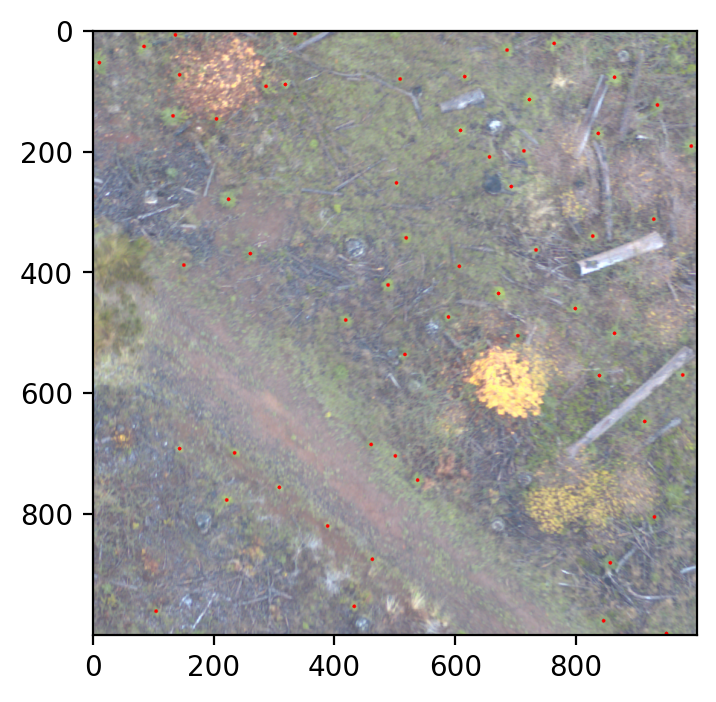

In [29]:
x = 2220
y = 3900
width = 1000 #must be divisible by 30 for now
height = 1000
cropped = crop(rgb65, x, y, width, height) #x coord, y coord, x length, y length
center_coords = get_saps(cropped)
mark_img(cropped, center_coords, x, y)

